In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [2]:
datapath = '/mnt/ssd/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
features = 'ressummaryfeaturesxgbNorbits10000.0Nout1000/'
dataset = pd.read_csv(datapath+dset+features+'trainingdata.csv', index_col = 0)
print(dataset.columns.values)

['Zcross12' 'Zcross13' 'Zcross23' 'maxj' 'maxk' 'maxi1' 'maxi2'
 'maxstrength' 'secondres' 'EMmed12' 'EMmax12' 'EMdrift12'
 'capseculartscale12' 'EMdetrendedstd12' 'EMrollingstd12' 'DiffcoeffEM12'
 'medvarEM12' 'Zmed12' 'Zmax12' 'Zdetrendedstd12' 'Zrollingstd12'
 'DiffcoeffZ12' 'medvarZ12' 'Zcomdrift12' 'Zcomrollingstd12'
 'phiZcomdrift12' 'phiZcomrollingstd12' 'Zstardrift12' 'Zstarrollingstd12'
 'Zcosphistd12' 'medZcosphi12' 'EMmed23' 'EMmax23' 'EMdrift23'
 'capseculartscale23' 'EMdetrendedstd23' 'EMrollingstd23' 'DiffcoeffEM23'
 'medvarEM23' 'Zmed23' 'Zmax23' 'Zdetrendedstd23' 'Zrollingstd23'
 'DiffcoeffZ23' 'medvarZ23' 'Zcomdrift23' 'Zcomrollingstd23'
 'phiZcomdrift23' 'phiZcomrollingstd23' 'Zstardrift23' 'Zstarrollingstd23'
 'Zcosphistd23' 'medZcosphi23' 'tlyap']


In [3]:
labels = pd.read_csv(datapath+dset+features+'labels.csv', index_col=0)
labels.tail()

,runstring,instability_time,shadow_instability_time,Stable
9994,0009995.bin,9.990000e+08,9.990000e+08,True
9995,0009996.bin,3.814426e+06,6.124299e+06,False
9996,0009997.bin,1.498363e+04,3.320307e+03,False
9997,0009998.bin,9.419807e+05,8.353625e+05,False
9998,0009999.bin,1.895071e+07,2.047024e+07,False


In [4]:
features = dataset.columns.values
y = labels['Stable']
X = dataset[features]
X.head()

,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,maxstrength,secondres,EMmed12,...,medvarZ23,Zcomdrift23,Zcomrollingstd23,phiZcomdrift23,phiZcomrollingstd23,Zstardrift23,Zstarrollingstd23,Zcosphistd23,medZcosphi23,tlyap
0,0.504063,0.594658,0.060234,12.0,1.0,2.0,3.0,0.048244,0.195509,0.081792,...,1.470918e-04,0.022942,0.000753,0.144823,0.004244,0.165598,0.033893,0.013167,-0.342346,-1.040976
1,0.240504,0.340424,0.080547,9.0,1.0,2.0,3.0,0.020943,0.032165,0.043415,...,9.235629e-05,0.037659,0.001800,0.050964,0.002007,0.027374,0.004149,0.069011,-0.684761,-2.109589
2,0.129660,1.261558,1.001981,6.0,1.0,1.0,2.0,0.067762,0.029946,0.298074,...,3.455619e-07,0.429699,0.013802,0.657982,0.019529,0.004231,0.000196,0.020795,0.000067,-1.227190
3,0.406112,1.007603,0.427768,5.0,2.0,1.0,2.0,0.045905,0.053205,0.090351,...,3.919548e-04,0.837173,0.054418,0.949626,0.048283,NaN,NaN,0.081875,0.000228,-1.166343
4,0.059897,0.332922,0.257596,12.0,1.0,1.0,2.0,0.030171,0.140455,0.398712,...,1.147811e-03,4.495888,0.297336,5.267933,0.106736,NaN,NaN,0.082738,0.001040,-1.085552


In [5]:
X.shape

(9999, 54)

In [6]:
Nrows = int(0.8*X.shape[0])
trainX = X.iloc[:Nrows, :]
trainY = y.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testY = y.iloc[Nrows:]
xgbc = XGBClassifier(seed = 0)

In [7]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [8]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [9]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.90916014                                          
ERROR                                               
0.0057037692185411175                               
HOLDOUT SCORE                                       
0.9253229682802517                                  
SCORE:                                                                        
0.9017110599999999                                                            
ERROR                                                                         
0.004895262313576677                                                          
HOLDOUT SCORE                                                                 
0.9160656211240323                                                            
SCORE:                                                                        
0.9085521400000001                                                            
ERROR                                             

0.006609749726602344                                                           
HOLDOUT SCORE                                                                  
0.8992378239976486                                                             
SCORE:                                                                         
0.8727848                                                                      
ERROR                                                                          
0.006924972909094153                                                           
HOLDOUT SCORE                                                                  
0.8911796117919372                                                             
SCORE:                                                                         
0.9098709600000001                                                             
ERROR                                                                          
0.006067942411952369                    

0.003648047759285245                                                           
HOLDOUT SCORE                                                                  
0.928417407917458                                                              
SCORE:                                                                         
0.85112784                                                                     
ERROR                                                                          
0.009290298836117778                                                           
HOLDOUT SCORE                                                                  
0.8778637027614944                                                             
SCORE:                                                                         
0.5                                                                            
ERROR                                                                          
0.0                                     

In [10]:
#fit the smaller rage 
#{'x_learning_rate': 0.07419653015127085,
# 'x_max_depth': 8,
# 'x_min_child': 4.0,
# 'x_pos_weight': 8.889472764333366,
# 'x_subsample': 0.9380315392096068,
# 'x_tree_colsample': 0.734517699234413}

#{'x_learning_rate': 0.19890696372714528,
# 'x_max_depth': 17,
# 'x_min_child': 8.0,
# 'x_pos_weight': 12.505309968632893,
# 'x_subsample': 0.9409498631912948,
# 'x_tree_colsample': 0.7528946858805113}

best

{'x_learning_rate': 0.18494326660606009,
 'x_max_depth': 12,
 'x_min_child': 7.0,
 'x_pos_weight': 2.8642438038964997,
 'x_subsample': 0.9776412552383459,
 'x_tree_colsample': 0.9187014903711288}

In [11]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.949205+0.000551666	test-auc:0.878956+0.00301564
[1]	train-auc:0.966976+0.00295742	test-auc:0.895488+0.00237222
[2]	train-auc:0.975391+0.00200492	test-auc:0.903693+0.00528206
[3]	train-auc:0.979472+0.00187279	test-auc:0.909301+0.00459252
[4]	train-auc:0.98224+0.00160768	test-auc:0.912787+0.00435327
[5]	train-auc:0.984344+0.00101315	test-auc:0.916742+0.0047327
[6]	train-auc:0.986287+0.000870238	test-auc:0.91855+0.00463771
[7]	train-auc:0.988124+0.000673848	test-auc:0.919999+0.00558721
[8]	train-auc:0.989769+0.00051712	test-auc:0.92231+0.00586762
[9]	train-auc:0.990926+0.000485782	test-auc:0.92443+0.00551259
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.949205       0.000552       0.878956      0.003016
1        0.966976       0.002957       0.895488      0.002372
2        0.975391       0.002005       0.903693      0.005282
3        0.979472       0.001873       0.909301      0.004593
4        0.982240       0.001608       0.912787      0.004353

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.8334743193650563


In [12]:
#try testing on the holdout set with these parameters
from sklearn.metrics import roc_auc_score

    
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

best_xgbc.fit(trainX, trainY)
preds = best_xgbc.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print(auc_Score)
print(metrics.average_precision_score(testY, preds))

0.941630696841201
0.8685779199808732


In [13]:
print(best)

{'x_learning_rate': 0.18494326660606009, 'x_max_depth': 12, 'x_min_child': 7.0, 'x_pos_weight': 2.8642438038964997, 'x_subsample': 0.9776412552383459, 'x_tree_colsample': 0.9187014903711288}


Text(0.5, 1.0, 'ROC curve (AUC = 0.942)')

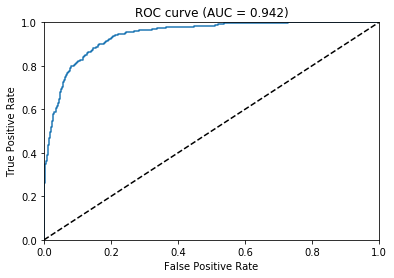

In [14]:
#the ROCAUC score is now 98.0 witht eh 2080 split compared to the 40 60 from before 
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(metrics.roc_auc_score(testY, preds)))

In [15]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(thresholds[i], recall[i], precision[i]))

Threshold 0.0009561293991282582, recall = 1.0, precision = 0.3374922021210231
Threshold 0.0010377868311479688, recall = 0.9981515711645101, precision = 0.34005037783375314
Threshold 0.0011487045558169484, recall = 0.9981515711645101, precision = 0.34329307056579783
Threshold 0.0012326824944466352, recall = 0.9981515711645101, precision = 0.3465982028241335
Threshold 0.0013397320872172713, recall = 0.9981515711645101, precision = 0.34996759559300067
Threshold 0.0014602829469367862, recall = 0.9981515711645101, precision = 0.35340314136125656
Threshold 0.0015415744855999947, recall = 0.9981515711645101, precision = 0.356906807666887
Threshold 0.0016536996699869633, recall = 0.9981515711645101, precision = 0.3604806408544726
Threshold 0.0017918881494551897, recall = 0.9981515711645101, precision = 0.3641267700606878
Threshold 0.0018855876987800002, recall = 0.9981515711645101, precision = 0.3678474114441417
Threshold 0.0019748557824641466, recall = 0.9981515711645101, precision = 0.371644

AUC Score (Test): 0.868578


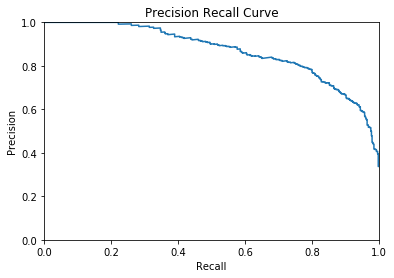

In [16]:
#draw precison recall curve
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
print("AUC Score (Test): %f" % metrics.average_precision_score(testY, preds))
plt.show()

[0.9834119  0.9781141  0.4670484  0.5628325  0.05434499]
541 1459
[960. 106.  54.  30.  25.  16.  16.  15.  13.  12.   8.  12.   5.   9.
   2.  11.   7.   6.   8.  10.   3.   7.   3.   3.   2.   3.   3.   3.
   8.   1.   3.   4.   3.   4.   0.   6.   3.   5.   0.   4.   4.   4.
   5.   9.   5.   4.   5.   9.   9.  12.]
[13 10  7  5  8  5  5  4  6  4  5  2  6  0  5  8  1  2  4  4  3  1  0  3
  2  2  5  3  7  2  2  9  4  4  5  6  7  8 10  4 13  6  5  9 11 15 20 28
 40 83]


(0, 350)

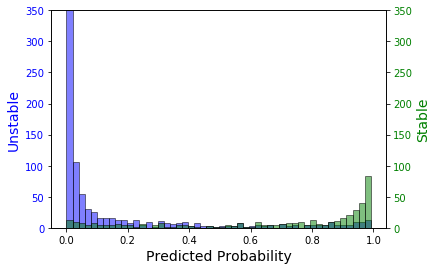

In [17]:
# Histogram:
bins = 50
Stable=preds[np.where(testY==1)]
print(Stable[:5][:])
Unstable=preds[np.where(testY==0)]
print(Stable.size, Unstable.size)


fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,350]) # goes up to ~4300
ax2.set_ylim([0,350]) # goes up to ~2100

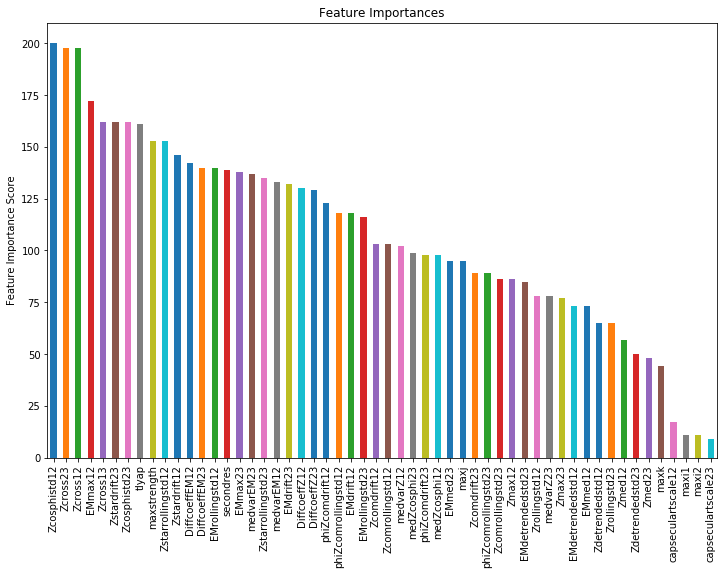

In [18]:
# feature importances
feat_imp = pd.Series(best_xgbc.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [19]:
import dill
import sys
dill.dump([best_xgbc, features], open(datapath+"../models/ressummaryfeaturesxgb_resonant.pkl", "wb"))